# PROCEDURE
- whe have a spread
- we have a z score
- we have prices for asset one and asset two
- can we use that information to predict the direction of the spread by at least 50/50?

# Imports

In [1]:
# DATA MANAGEMENT
import numpy as np
import pandas as pd

# DATA PREPROCESSING
from sklearn.preprocessing import StandardScaler

# UNSUPERVISED MACHINE LEARNING
from sklearn.decomposition import PCA

# DEEP LEARNING
import torch 
from torch import nn
from torch.utils.data import Dataset, DataLoader

# VISUALIZATION
import matplotlib.pyplot as plt

# Data Extraction

In [2]:
# Load data from saved file 
df = pd.read_csv("../1_Unsupervised/data-storage/pair_trade.csv")
df.drop(columns="Date", inplace=True)

# Feature Engineering

In [3]:
# ADDING FEATURES


# DAILY LOG RETURNS
df["log_returns_Asset_1"] = np.log(df['Asset1'] / df["Asset1"].shift(1))
df["log_returns_Asset_2"] = np.log(df['Asset2'] / df["Asset2"].shift(1))

# 21 DAY ROLLING AVERAGE OF LOG RETURNS
df["log_returns_Asset_1_ROLLING"] = df["log_returns_Asset_1"].rolling(window=21).mean()
df["log_returns_Asset_2_ROLLING"] = df["log_returns_Asset_2"].rolling(window=21).mean()

# CUMALATIVE SUM
df["Sum_Returns_Asset_1"] = df["log_returns_Asset_1"].cumsum()
df["Sum_Returns_Asset_2"] = df["log_returns_Asset_2"].cumsum()


# drop nulls
df.dropna(inplace=True)


print("amount of days: ",len(df))
df.head(5)

amount of days:  845


,Asset1,Asset2,Spread,ZScore,log_returns_Asset_1,log_returns_Asset_2,log_returns_Asset_1_ROLLING,log_returns_Asset_2_ROLLING,Sum_Returns_Asset_1,Sum_Returns_Asset_2
21,65.849998,43.740002,1.909264,-1.089874,-0.022820,-0.021934,0.001379,0.001741,0.028965,0.036554
22,66.680000,44.380001,1.803691,-1.214013,0.012526,0.014526,0.001516,0.002173,0.041491,0.051080
23,65.820000,43.709999,1.923124,-1.029978,-0.012981,-0.015212,0.000298,0.001247,0.028509,0.035868
24,66.050003,44.029999,1.685340,-1.329987,0.003488,0.007294,-0.000381,0.001138,0.031998,0.043162
25,67.349998,44.520000,2.269033,-0.517238,0.019491,0.011067,0.000305,0.001208,0.051489,0.054230


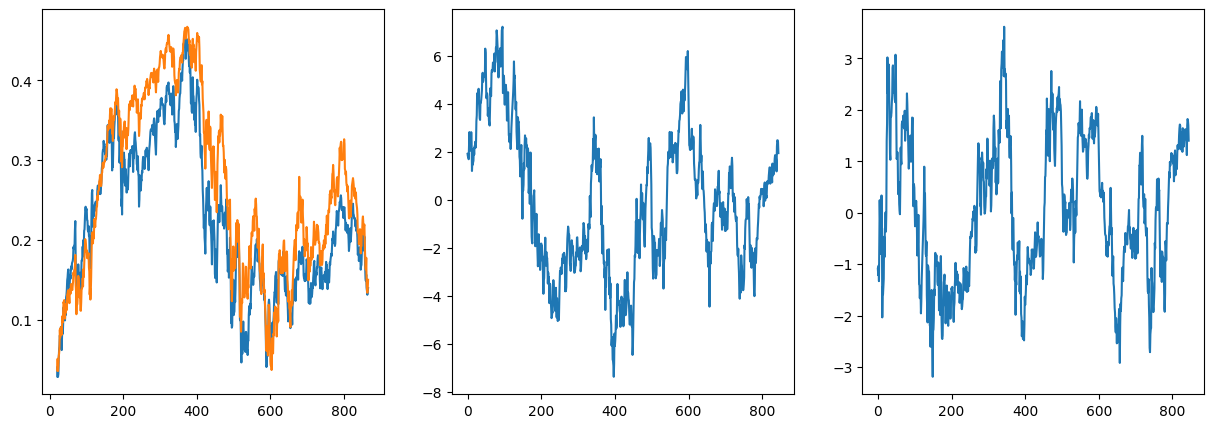

In [4]:
# VISUALIZE DATA
fig = plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(df["Sum_Returns_Asset_1"])
plt.plot(df["Sum_Returns_Asset_2"])

plt.subplot(1,3,2)
plt.plot(df["Spread"].values)

plt.subplot(1,3,3)
plt.plot(df["ZScore"].values)


# TARGET COLUMN

In [5]:
# ARE WE REACHING A POSITIVE SPREAD?
future_step = 1
df["TARGET"] = 0
df.loc[  df["Spread"].shift(-future_step)  >  0  , "TARGET" ]   =   1
df.dropna(inplace=True)

df.tail(5)

,Asset1,Asset2,Spread,ZScore,log_returns_Asset_1,log_returns_Asset_2,log_returns_Asset_1_ROLLING,log_returns_Asset_2_ROLLING,Sum_Returns_Asset_1,Sum_Returns_Asset_2,TARGET
861,73.599998,48.840000,2.203900,1.697467,-0.016307,-0.030846,-0.001591,-0.002284,0.140231,0.146841,1
862,73.269997,48.430000,2.473251,1.821666,-0.004494,-0.008430,-0.002141,-0.002936,0.135737,0.138410,1
863,72.949997,48.209999,2.474857,1.790427,-0.004377,-0.004553,-0.002832,-0.003640,0.131360,0.133857,1
864,73.239998,48.459999,2.399399,1.701699,0.003967,0.005172,-0.002378,-0.003549,0.135327,0.139030,1
865,73.570000,49.000000,1.940007,1.401125,0.004496,0.011082,-0.001872,-0.002619,0.139823,0.150111,0


## TRAIN TEST SPLIT

In [6]:
X_data = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

len(X_data), len(y) 

(845, 845)

## Scaling Data

In [7]:
# Scaling Features
scaler = StandardScaler()

# Transform Values to propper scale size
x = scaler.fit_transform(X_data)

### DATA LOAD STRUCTURING

In [8]:
# Dataset Class
class dataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float)
        self.y = torch.tensor(y, dtype=torch.float)
        self.length = self.x.shape[0]
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
    def __len__(self):
        return self.length




trainset = dataset(x , y)
trainloader = DataLoader(trainset , batch_size=64  , shuffle=False)

In [9]:
# review x data
trainloader.dataset.x[:5]

tensor([[-1.8716, -1.8527,  0.6744, -0.8320, -1.6114, -1.6456,  0.4568,  0.5805,
         -2.0529, -2.0341],
        [-1.7652, -1.7484,  0.6391, -0.9229,  0.8731,  1.0764,  0.5081,  0.7409,
         -1.9215, -1.9027],
        [-1.8754, -1.8575,  0.6790, -0.7881, -0.9198, -1.1438,  0.0523,  0.3976,
         -2.0577, -2.0403],
        [-1.8459, -1.8054,  0.5995, -1.0079,  0.2379,  0.5365, -0.2012,  0.3572,
         -2.0211, -1.9743],
        [-1.6793, -1.7256,  0.7946, -0.4124,  1.3627,  0.8182,  0.0551,  0.3830,
         -1.8167, -1.8743]])

In [10]:
# review y data
trainloader.dataset.y[:5]

tensor([1., 1., 1., 1., 1.])

# Build Neural Network

- Node Layer `self.fc3` equals a layer object with 64 nodes coming in and one node coming out `True or False`
- `self.fc3 = nn.Linear(64, 1)`

In [11]:
class Net(nn.Module):
    def __init__(self, input_shape):
        super(Net, self).__init__()

        # INPUT LAYER
        self.fc1 = nn.Linear(input_shape, 32)

        # HIDDEN LAYER
        self.fc2 = nn.Linear(32, 64)

        # OUTPUT LAYER
        self.fc3 = nn.Linear(64, 1)


    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x


# Train Neural Netowrks

In [12]:
# HYPER PARAMETER TUNING
learning_rate = 0.01
epochs = 1000

# Model
model = Net(input_shape=x.shape[1])

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# Loss
loss_func = nn.BCELoss()

In [16]:
# Forward Loop
losses = []
accuracy = []


# FOR THE AMOUNT OF EPOCHS    (iterations) 
# GO THROUGH EACH X & Y VALUE (training data)

for i in range(epochs):
    for j , (x_train, y_train) in enumerate(trainloader):
        
        # CALCULATE OUTPUT
        output = model(x_train)

        # CALCULATE LOSS
        loss = loss_func(output, y_train.reshape(-1,1))

        # CALCULATE ACCURACY
        predicted = model(torch.tensor(x,dtype=torch.float32))
        acc = (predicted.detach().numpy().round() == y).mean()


        # BACKDROP
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # DISPLAY RESULTS
        if i % 50 == 0:
            losses.append(loss.detach())
            accuracy.append(acc)
            print(f"Epoch: {i}, Loss: {loss}, Accuracy: {acc}")


Epoch: 0, Loss: 8.984256965050008e-06, Accuracy: 0.5014180175764154
Epoch: 0, Loss: 0.0, Accuracy: 0.5014180175764154
Epoch: 0, Loss: 0.0005624567274935544, Accuracy: 0.5014180175764154
Epoch: 0, Loss: 4.596944052082108e-07, Accuracy: 0.5014180175764154
Epoch: 0, Loss: 0.0007781550521031022, Accuracy: 0.5014180175764154
Epoch: 0, Loss: 0.008624193258583546, Accuracy: 0.5014180175764154
Epoch: 0, Loss: 2.656759708064005e-11, Accuracy: 0.5014180175764154
Epoch: 0, Loss: 0.0069693005643785, Accuracy: 0.5014180175764154
Epoch: 0, Loss: 9.166002564597875e-05, Accuracy: 0.5014180175764154
Epoch: 0, Loss: 2.762383155641146e-05, Accuracy: 0.5014180175764154
Epoch: 0, Loss: 0.003952801693230867, Accuracy: 0.5014180175764154
Epoch: 0, Loss: 0.009099808521568775, Accuracy: 0.5014180175764154
Epoch: 0, Loss: 0.002724637743085623, Accuracy: 0.5014180175764154
Epoch: 0, Loss: 0.0008041905821301043, Accuracy: 0.5014180175764154
Epoch: 50, Loss: 0.0, Accuracy: 0.5014180175764154
Epoch: 50, Loss: 0.0, 

# VISUALIZE LOSS PREFORMANCE

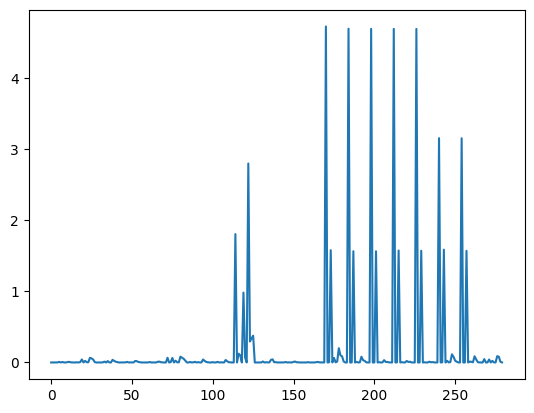

In [17]:
# VISUALIZE LOSSES 
plt.plot(losses)
plt.show()